<a href="https://colab.research.google.com/github/swarnamchellaiah/number-plate-detection/blob/main/number_plate_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Install all required dependencies for license plate detection project
!pip install opencv-python-headless
!pip install easyocr
!pip install imutils
!pip install numpy
!pip install matplotlib

# Install system dependencies (needed for OpenCV)
!apt-get update && apt-get install -y libgl1-mesa-glx

# Verify installations
import cv2
import numpy as np
import easyocr
import imutils
import matplotlib.pyplot as plt

print("OpenCV version:", cv2.__version__)
print("NumPy version:", np.__version__)
print("Imutils version:", imutils.__version__)

# Initialize EasyOCR to verify installation
reader = easyocr.Reader(['en'])
print("EasyOCR successfully initialized!")

print("\nAll dependencies installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

OpenCV version: 4.11.0
NumPy version: 2.0.2
Imutils version: 0.5.4
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteEasyOCR successfully initialized!

All dependencies installed successfully!


License Plate Detection and Recognition
--------------------------------------
Running in Google Colab environment
Note: In Colab, real-time webcam processing isn't directly possible.
Upload a video file below:


Saving car8.jpg to car8 (1).jpg
Processing image: car8 (1).jpg
Detected license plate: MH 20 EE 7602


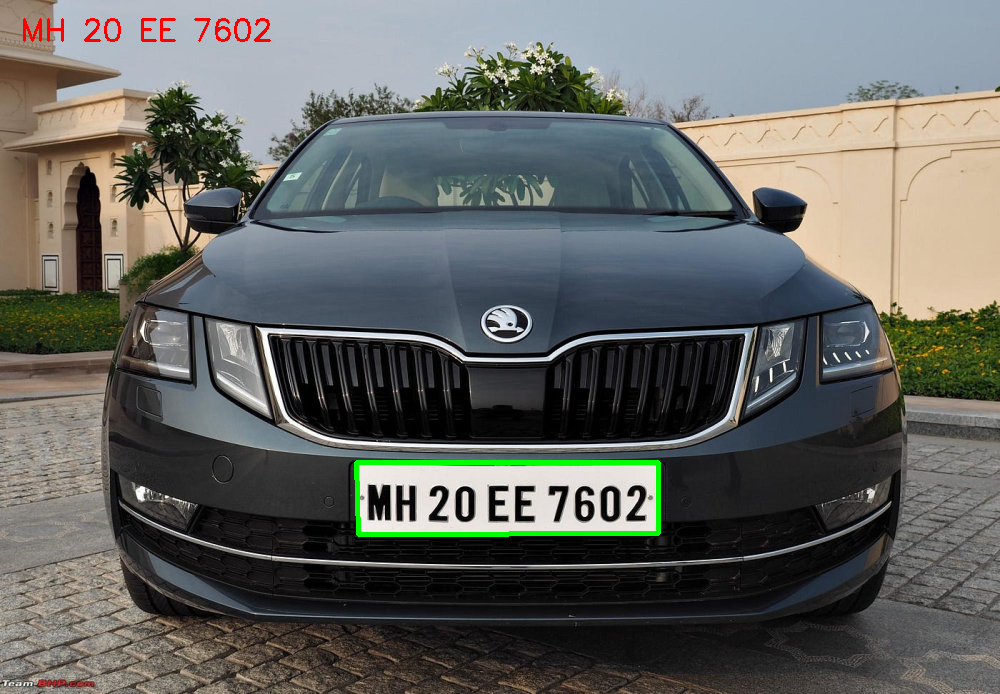

Cropped License Plate:


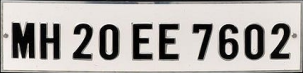

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
# Real-time License Plate Detection & Recognition
# Install required packages


import cv2
import numpy as np
import easyocr
import imutils
import re
from google.colab.patches import cv2_imshow
from google.colab import files
import time

# Initialize the OCR reader
reader = easyocr.Reader(['en'], gpu=True)

def detect_plate(image):
    """Detect license plate in the given image"""

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply bilateral filter to remove noise while keeping edges sharp
    filtered = cv2.bilateralFilter(gray, 11, 17, 17)

    # Detect edges
    edged = cv2.Canny(filtered, 30, 200)

    # Find contours
    cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]

    location = None
    for c in cnts:
        # Approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.018 * peri, True)

        # Look for contours with 4 corners (rectangle)
        if len(approx) == 4:
            location = approx
            break

    return location

def recognize_plate_text(image, location):
    """Extract and recognize text from plate region"""
    if location is None:
        return "No plate detected", None

    # Create a mask for the plate region
    mask = np.zeros(image.shape[0:2], dtype=np.uint8)
    cv2.drawContours(mask, [location], 0, 255, -1)

    # Apply the mask to get only the plate region
    (x, y) = np.where(mask == 255)
    (topx, topy) = (np.min(x), np.min(y))
    (bottomx, bottomy) = (np.max(x), np.max(y))
    plate_region = image[topx:bottomx+1, topy:bottomy+1]

    # Use OCR to read text from the plate
    try:
        result = reader.readtext(plate_region)
        text = ""
        for detection in result:
            text += detection[1] + " "

        # Clean the text (remove non-alphanumeric characters)
        cleaned_text = re.sub(r'[^A-Za-z0-9 ]', '', text.strip())

        return cleaned_text, plate_region
    except Exception as e:
        return f"Error: {str(e)}", plate_region

def process_image(image):
    """Process a single image to detect and recognize license plate"""

    # Resize if the image is too large
    if image.shape[0] > 1000 or image.shape[1] > 1000:
        image = imutils.resize(image, width=1000)

    original = image.copy()

    # Detect license plate
    location = detect_plate(image)

    if location is not None:
        # Draw the contour of the plate
        cv2.drawContours(image, [location], -1, (0, 255, 0), 3)

        # Recognize text on the plate
        plate_text, plate_region = recognize_plate_text(original, location)

        # Display the recognized text
        if plate_text:
            cv2.putText(image, plate_text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        return image, plate_text, plate_region
    else:
        return image, "No plate detected", None


def process_video(video_path=0):
    """Process video to detect and recognize license plates in real-time"""
    try:
        # If using Google Colab, we'll need to process uploaded video or images
        print("Note: In Colab, real-time webcam processing isn't directly possible.")
        print("Upload a video file below:")

        # Upload a file
        uploaded = files.upload()

        for filename in uploaded.keys():
            # Check if it's a video file
            if filename.endswith(('.mp4', '.avi', '.mov')):
                print(f"Processing video: {filename}")
                cap = cv2.VideoCapture(filename)

                # Check if video opened successfully
                if not cap.isOpened():
                    print(f"Error: Could not open video file {filename}")
                    continue

                # Get video properties
                fps = cap.get(cv2.CAP_PROP_FPS)
                width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

                print(f"Video properties: {width}x{height} at {fps} FPS")

                # Make sure dimensions are valid
                if width <= 0 or height <= 0:
                    print("Error: Invalid video dimensions")
                    continue

                # Create video writer for output
                output_filename = 'output_' + filename

                # For Google Colab compatibility, use MP4V codec
                fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use mp4v codec for better compatibility

                # Create writer
                out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

                # Check if writer initialized properly
                if not out.isOpened():
                    print("Error: Could not create output video writer")
                    print("Trying with a different codec...")

                    # Try with a different codec
                    fourcc = cv2.VideoWriter_fourcc(*'XVID')
                    out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

                    if not out.isOpened():
                        print("Error: Could not create output video with alternative codec")
                        cap.release()
                        continue

                frame_count = 0
                processed_count = 0
                start_time = time.time()

                while True:
                    ret, frame = cap.read()
                    if not ret:
                        break

                    frame_count += 1

                    # Process every 5th frame for speed
                    if frame_count % 5 == 0:
                        processed_count += 1

                        try:
                            # Make a copy to avoid modifying the original frame
                            process_frame = frame.copy()

                            # Ensure frame is in proper format
                            if process_frame is None or process_frame.size == 0:
                                print(f"Warning: Empty frame at {frame_count}, skipping")
                                out.write(frame)  # Write original frame instead
                                continue

                            # Process the frame
                            processed_frame, plate_text, _ = process_image(process_frame)

                            # Ensure processed frame is valid and the same dimensions as original
                            if processed_frame.shape[0] != height or processed_frame.shape[1] != width:
                                processed_frame = cv2.resize(processed_frame, (width, height))

                            # Write the processed frame
                            out.write(processed_frame)

                            # Display progress
                            if processed_count % 10 == 0:  # Update every 10 processed frames
                                elapsed_time = time.time() - start_time
                                fps_processing = frame_count / elapsed_time
                                print(f"Processed {frame_count} frames. FPS: {fps_processing:.2f}. Last plate: {plate_text}")

                        except Exception as e:
                            print(f"Error processing frame {frame_count}: {str(e)}")
                            # Write the original frame instead
                            out.write(frame)
                    else:
                        # Write the original frame for frames we're skipping
                        out.write(frame)

                # Release resources
                cap.release()
                out.release()
                print(f"\nVideo processing complete. Total frames: {frame_count}")

                # Verify the output file exists and has content
                import os
                if os.path.exists(output_filename):
                    file_size = os.path.getsize(output_filename)
                    print(f"Output file size: {file_size} bytes")

                    if file_size > 1000:  # File should be larger than 1KB to be valid
                        print(f"Output saved as {output_filename}")

                        # Convert to MP4 format for compatibility
                        mp4_output = output_filename.split('.')[0] + '.mp4'

                        # Use ffmpeg to ensure proper encoding (install if needed)
                        try:
                            !pip install ffmpeg-python
                            import ffmpeg

                            # Convert the output to properly encoded MP4
                            !ffmpeg -i {output_filename} -c:v libx264 -preset fast -crf 23 -y {mp4_output}

                            print(f"Converted output to {mp4_output} for better compatibility")
                            files.download(mp4_output)
                        except:
                            print("Could not convert to MP4. Downloading original output.")
                            files.download(output_filename)
                    else:
                        print(f"Warning: Output file is very small ({file_size} bytes). There might be an encoding issue.")
                        # Try to create a video from frames as backup
                        print("Attempting alternative method...")
                else:
                    print(f"Error: Output file {output_filename} was not created")

            # If it's an image file
            elif filename.endswith(('.jpg', '.jpeg', '.png')):
                print(f"Processing image: {filename}")
                image = cv2.imread(filename)

                if image is None:
                    print(f"Error: Could not read image {filename}")
                    continue

                processed_image, plate_text, plate_region = process_image(image)

                print(f"Detected license plate: {plate_text}")

                # Show the processed image
                cv2_imshow(processed_image)

                # If plate region was found, show it separately
                if plate_region is not None:
                    print("Cropped License Plate:")
                    cv2_imshow(plate_region)

                # Save and offer download of the processed image
                output_filename = 'processed_' + filename
                cv2.imwrite(output_filename, processed_image)
                files.download(output_filename)

            else:
                print(f"Unsupported file type: {filename}")
                print("Please upload an image (.jpg, .jpeg, .png) or video (.mp4, .avi, .mov) file.")

    except Exception as e:
        print(f"Error: {str(e)}")
        import traceback
        traceback.print_exc()

def main():
    print("License Plate Detection and Recognition")
    print("--------------------------------------")
    print("Running in Google Colab environment")
    process_video()

if __name__ == "__main__":
    main()